<a href="https://colab.research.google.com/github/kkokay07/genomicclass/blob/master/ML_logistic_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Cancer Classification using Logistic Regression - Mathematical Approach

## 1. Introduction to Logistic Regression

### Mathematical Foundation

Logistic Regression is based on the following mathematical concepts:

1) **The Logistic Function (Sigmoid)**:
   $$\sigma(z) = \frac{1}{1 + e^{-z}}$$

2) **Linear Combination**:
   $$z = w_0 + w_1x_1 + w_2x_2 + ... + w_nx_n = w^Tx + b$$

3) **Probability Estimation**:
   $$P(Y=1|X) = \sigma(w^TX + b)$$

### Why Logistic Regression for SNP Analysis?
- Handles multiple classes (different cancer types)
- Provides probabilistic output
- Interpretable feature importance
- Works well with categorical data (SNP genotypes)

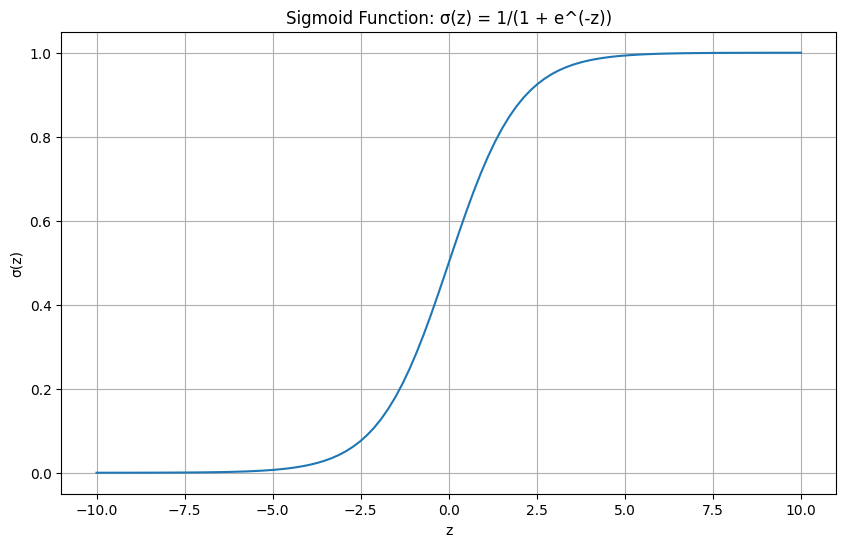

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# Plot the sigmoid function
x = np.linspace(-10, 10, 100)
sigmoid = 1/(1 + np.exp(-x))

plt.figure(figsize=(10, 6))
plt.plot(x, sigmoid)
plt.title('Sigmoid Function: σ(z) = 1/(1 + e^(-z))')
plt.xlabel('z')
plt.ylabel('σ(z)')
plt.grid(True)
plt.show()

## 2. Data Loading and Preprocessing

### Understanding SNP Data
SNP values represent genotypes:
- 1: Homozygous reference (AA)
- 2: Heterozygous (AB)
- 3: Homozygous alternate (BB)

Dataset Information:
Number of samples: 262
Number of SNPs: 645

First few rows of the data:


,Individuals,HD0100001401,BFGL-NGS-62077,HD0100002373,HD0100010085,HD0100012520,HD0100015487,HD0100015803,HD0100016678,HD0100016761,...,HD2800008319,HD2800009580,HD2800010158,HD2800011791,BFGL-NGS-32198,HD2900014986,HD2900005308,HD2900015344,HD2900015407,HD2900012940
0,Lung_Cancer,1,1,1,1,1,1,3,3,3,...,3,3,1,3,1,3,1,3,1,3
1,Lung_Cancer,1,2,1,1,1,1,3,3,3,...,3,3,1,3,1,3,1,3,1,3
2,Lung_Cancer,1,2,1,1,1,1,3,3,3,...,3,3,1,3,1,3,1,3,1,3
3,Lung_Cancer,1,1,1,1,1,1,3,3,3,...,3,3,1,3,1,3,1,3,1,3
4,Lung_Cancer,1,1,1,1,1,1,3,3,3,...,3,3,1,3,1,3,1,3,1,3


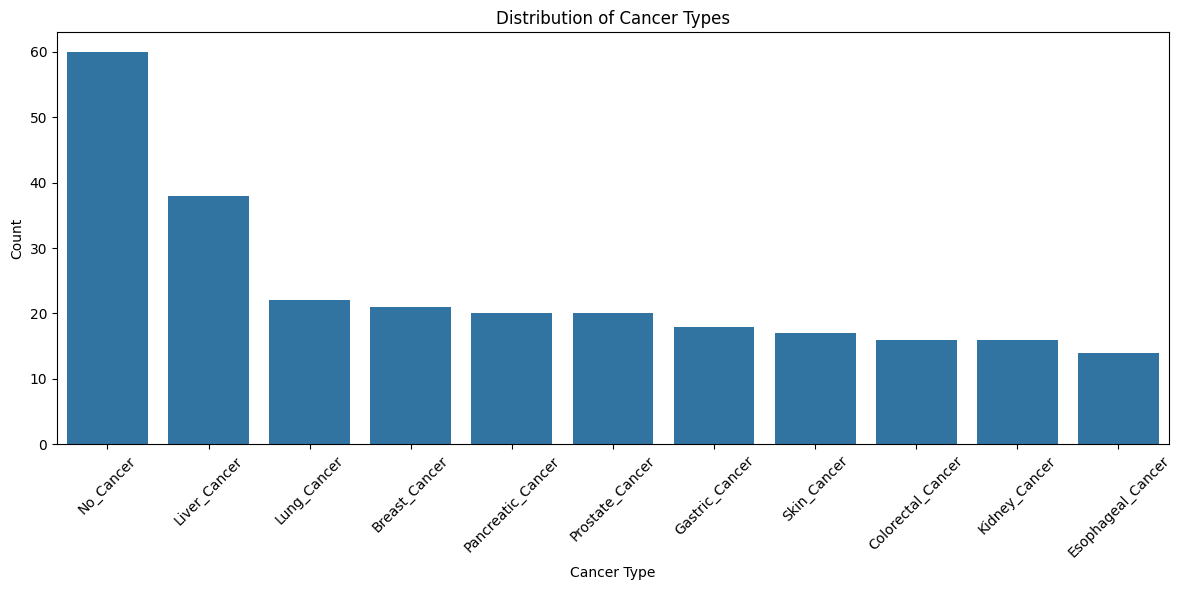

In [5]:
# Load the data
data = pd.read_csv('common_cancers.csv')

print("Dataset Information:")
print(f"Number of samples: {len(data)}")
print(f"Number of SNPs: {len(data.columns)-1}")

# Display first few rows
print("\nFirst few rows of the data:")
display(data.head())

# Plot distribution of cancer types
plt.figure(figsize=(12, 6))
cancer_counts = data.iloc[:, 0].value_counts()
sns.barplot(x=cancer_counts.index, y=cancer_counts.values)
plt.title('Distribution of Cancer Types')
plt.xlabel('Cancer Type')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## 3. Data Preprocessing

### Feature Scaling
We standardize features using the formula:
$$X_{scaled} = \frac{X - \mu}{\sigma}$$

Where:
- μ is the mean
- σ is the standard deviation

In [6]:
# Split features and target
X = data.iloc[:, 1:]  # SNP features
y = data.iloc[:, 0]   # Cancer types

# Split into training (80%) and testing (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=42,
                                                    stratify=y)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Training set shape:", X_train_scaled.shape)
print("Testing set shape:", X_test_scaled.shape)

# Show feature statistics before and after scaling
print("\nFeature statistics before scaling:")
print(pd.DataFrame(X_train).describe().loc[['mean', 'std']].round(2))

print("\nFeature statistics after scaling:")
print(pd.DataFrame(X_train_scaled).describe().loc[['mean', 'std']].round(2))

Training set shape: (209, 645)
Testing set shape: (53, 645)

Feature statistics before scaling:
      HD0100001401  BFGL-NGS-62077  HD0100002373  HD0100010085  HD0100012520  \
mean          1.84            1.93          1.82          1.88          1.92   
std           0.93            0.95          0.93          0.93          0.97   

      HD0100015487  HD0100015803  HD0100016678  HD0100016761  HD0100017653  \
mean          1.90          1.84          2.00          1.92          2.12   
std           0.97          0.95          1.09          1.06          0.93   

      ...  HD2800008319  HD2800009580  HD2800010158  HD2800011791  \
mean  ...          2.06          1.95          1.97          2.04   
std   ...          0.95          1.01          0.99          0.98   

      BFGL-NGS-32198  HD2900014986  HD2900005308  HD2900015344  HD2900015407  \
mean            1.89          1.99          2.01          1.95          1.93   
std             0.96          0.94          1.01          1.

## 4. Model Training

### Multinomial Logistic Regression
For K classes, probability for each class k is calculated as:

$$P(Y=k|X) = \frac{e^{w_k^TX}}{\sum_{j=1}^K e^{w_j^TX}}$$

The model minimizes the cross-entropy loss:
$$L = -\sum_{i=1}^n \sum_{k=1}^K y_{ik}\log(p_{ik})$$

In [7]:
# Create and train the model
model = LogisticRegression(max_iter=1000,
                          multi_class='multinomial',
                          solver='lbfgs')

print("Training the model...")
model.fit(X_train_scaled, y_train)

# Make predictions
y_pred = model.predict(X_test_scaled)
y_pred_prob = model.predict_proba(X_test_scaled)

print("\nModel trained successfully!")

Training the model...


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(



Model trained successfully!


## 5. Model Evaluation

### Key Metrics

1. **Accuracy**:
   $$\text{Accuracy} = \frac{\text{Correct Predictions}}{\text{Total Predictions}}$$

2. **Precision** (for each class):
   $$\text{Precision} = \frac{\text{True Positives}}{\text{True Positives + False Positives}}$$

3. **Recall** (for each class):
   $$\text{Recall} = \frac{\text{True Positives}}{\text{True Positives + False Negatives}}$$

Model Accuracy: 98.11%

Detailed Classification Report:
                   precision    recall  f1-score   support

    Breast_Cancer       1.00      1.00      1.00         4
Colorectal_Cancer       1.00      1.00      1.00         3
Esophageal_Cancer       1.00      1.00      1.00         3
   Gastric_Cancer       1.00      1.00      1.00         4
    Kidney_Cancer       1.00      0.67      0.80         3
     Liver_Cancer       1.00      1.00      1.00         8
      Lung_Cancer       1.00      1.00      1.00         5
        No_Cancer       1.00      1.00      1.00        12
Pancreatic_Cancer       1.00      1.00      1.00         4
  Prostate_Cancer       1.00      1.00      1.00         4
      Skin_Cancer       0.75      1.00      0.86         3

         accuracy                           0.98        53
        macro avg       0.98      0.97      0.97        53
     weighted avg       0.99      0.98      0.98        53



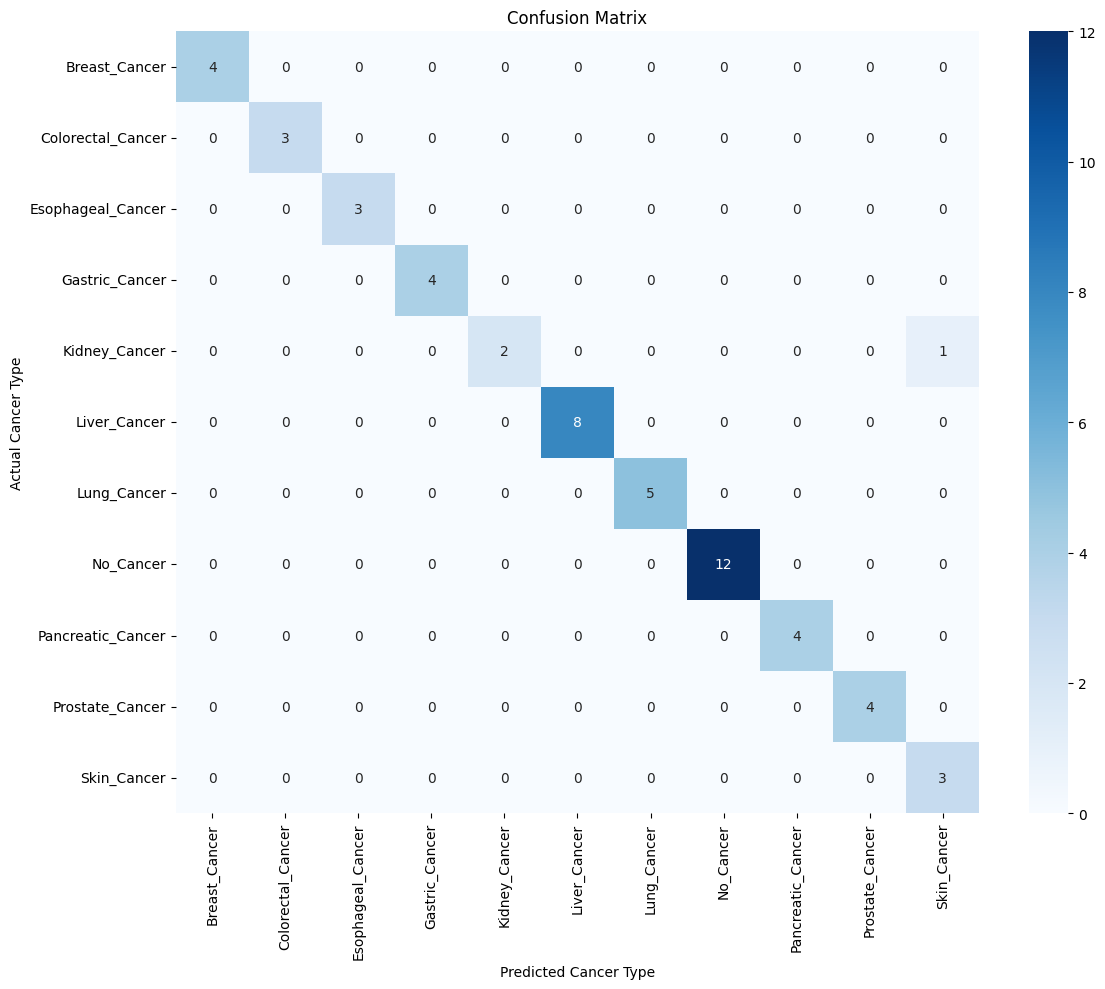

In [8]:
# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy:.2%}")

print("\nDetailed Classification Report:")
print(classification_report(y_test, y_pred))

# Create confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(conf_matrix,
            annot=True,
            fmt='d',
            cmap='Blues',
            xticklabels=model.classes_,
            yticklabels=model.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Cancer Type')
plt.ylabel('Actual Cancer Type')
plt.tight_layout()
plt.show()

## 6. Feature Importance Analysis

### Mathematical Interpretation
For each feature i, importance is calculated as:
$$\text{Importance}_i = \frac{1}{K}\sum_{k=1}^K |w_{ik}|$$

Where:
- K is the number of classes
- $w_{ik}$ is the coefficient for feature i in class k

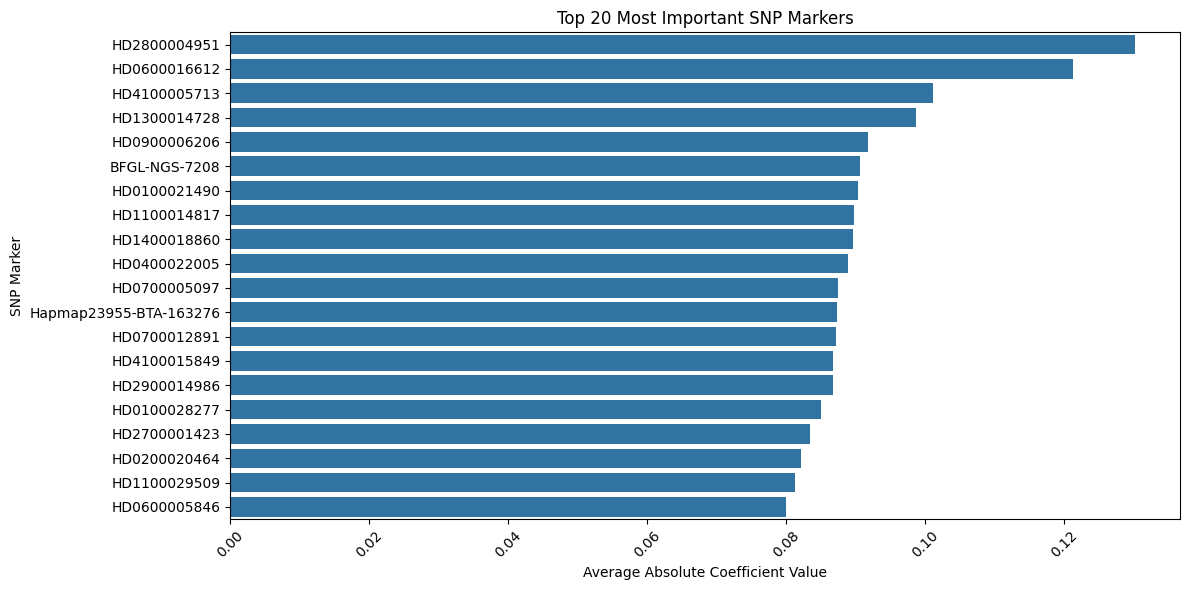


Top 10 Most Important SNP Markers:
               SNP  Importance
630   HD2800004951    0.130211
191   HD0600016612    0.121368
202   HD4100005713    0.101139
381   HD1300014728    0.098739
267   HD0900006206    0.091786
384  BFGL-NGS-7208    0.090583
13    HD0100021490    0.090366
323   HD1100014817    0.089737
404   HD1400018860    0.089672
117   HD0400022005    0.088901


In [9]:
# Calculate feature importance
feature_importance = pd.DataFrame({
    'SNP': X.columns,
    'Importance': np.abs(model.coef_).mean(axis=0)
})

# Sort by importance
feature_importance = feature_importance.sort_values('Importance', ascending=False)

# Plot top 20 features
plt.figure(figsize=(12, 6))
sns.barplot(data=feature_importance.head(20), x='Importance', y='SNP')
plt.title('Top 20 Most Important SNP Markers')
plt.xlabel('Average Absolute Coefficient Value')
plt.ylabel('SNP Marker')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Print top 10 SNPs
print("\nTop 10 Most Important SNP Markers:")
print(feature_importance.head(10))